In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import tensorflow as tf

In [2]:
def load_model(model_name):
    json_file = open('model/' + model_name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    loaded_model.load_weights('model/' + model_name + '_weights.h5')
    print('Loaded model: ', model_name)
    return loaded_model

In [3]:
def predict_model(img, model, show_details=False, image_size=(160, 160)):
    x = tf.image.resize(img, image_size)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict_on_batch(x).flatten()
    predictions = tf.nn.sigmoid(predictions)
    return predictions.numpy()[0]

In [4]:
class Image:
    
    def __init__(self, name, image_or_path):
        self.name = name
        self.get_image(image_or_path)
        self.mirrored = False
        
        
    def get_image(self, image_or_path):
        if isinstance(image_or_path, str):
            self.get_image_from_path(path)
            
        else:
            self.image = image_or_path
            
    
    def get_image_from_path(self, path):
        img = tf.keras.preprocessing.image.load_img(path)
        self.image = tf.keras.preprocessing.image.img_to_array(img)
        
    
    def mirror(self):
        self.image = cv2.flip(self.image, 1)
        self.mirrored = not self.mirrored
        self.name = self.name+'_mirror' if self.mirrored else self.name.split('_mirror')[0] 
    

    def show(self):
        plt.title(self.name)
        plt.imshow(self.image.astype(np.uint8))
        
    
    def predict(self, model):
        return predict_model(self.image, model)
        

In [5]:
class Eye(Image):
    
    model = load_model('model_eye_right')
    
    def __init__(self, name_face, image, side='right'):
        self.name_face = name_face
        self.side = side
        super().__init__(name_face+'_'+side+'_eye', image)
        self.predict_open()
        
    
    def predict_open(self):
        if self.side == 'left':
            self.mirror()
        self.open = self.predict(self.model) # closed 0 - open 1
            

Loaded model:  model_eye_right


In [6]:
class Face(Image):
    
    model_sunglasses = load_model('model_sunglasses')
    model_blurry = load_model('model_blurry')
    model_profile = load_model('model_profile')
    
    def __init__(self, name, image_or_path=None, eyes=2):
        super().__init__(name, image_or_path)   
        self.predictions()
        

    def get_eyes(self, eyes):
        if eyes == 1:
            print('Not implemented yet')
            
        if eyes == 2:
            eye1 = Eye(self.name, self.crop_eye())
            eye2 = Eye(self.name, self.crop_eye(side='left'), 'left')
        
        self.eye = (eye1, eye2)
        
        
    def open_eyes(self):
        pass
        
    
    def crop_eye(self, side='right', amplitude=0.45, height=0.1, wide=0.1):
        if side == 'right':
            image_eye = self.image[round(self.image.shape[0] * height):round(self.image.shape[0] * (height + amplitude)),
                       round(self.image.shape[1] * wide):round(self.image.shape[1] * (amplitude + wide))]
        else:
            image_eye = self.image[round(self.image.shape[0] * height):round(self.image.shape[0] * (height + amplitude)),
                       round(self.image.shape[1] * (1 - (amplitude + wide))):round(self.image.shape[1] * (1 - wide))]
        return image_eye
    
    
    def predict_blurry(self):
        self.blurry = 1 - self.predict(self.model_blurry) # not blurry 0 - blurry 1
        
    def predict_profile(self):
        self.profile = self.predict(self.model_profile) # not profile 0 - profile 1
        
    def predict_sunglasses(self):
        self.sunglasses = 1 - self.predict(self.model_sunglasses) # not sunglasses 0 - sunglasses 1
        
        
    def show_predictions(self, threshold=0.5):
        if self.blurry > threshold:
            print('Blurry image')
            print('blurry:', round(self.blurry,3))
        elif self.profile > threshold:
            print('Profile image')
            print('profile:', round(self.profile,3))
        elif self.sunglasses > threshold:
            print('Sunglasses image')
            print('sunglasses:', round(self.sunglasses,3))
        else:
            if self.eye[0].open>threshold and self.eye[1].open>threshold:
                print('Open eyes:')
            elif self.eye[0].open<threshold and self.eye[1].open<threshold:
                print('Closed eyes:')
            else:
                print('Unknown:')            
            print('prediction:', (round(self.eye[0].open,4), round(self.eye[1].open,4)))
        
    
    def predictions(self, threshold=0.5):
        self.predict_blurry()
        if self.blurry < threshold:
            self.predict_profile()
            if self.profile < threshold:
                self.predict_sunglasses()
                if self.sunglasses < threshold:
                    self.get_eyes(eyes=2)
                    self.open_eyes()
            
        

Loaded model:  model_sunglasses
Loaded model:  model_blurry
Loaded model:  model_profile


Closed eyes:
prediction: (0.0092, 0.0115)


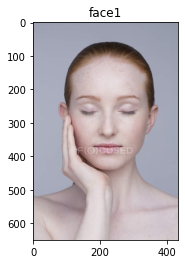

In [7]:
path='../data/test/open_test/closed5.jpg'
face1 = Face('face1', image_or_path=path)
face1.show()
face1.show_predictions()

Open eyes:
prediction: (0.7631, 0.7823)


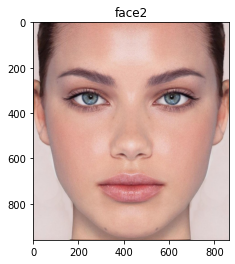

In [8]:
path='../data/test/open_test/open2.jpg'
face2 = Face('face2', image_or_path=path)
face2.show()
face2.show_predictions()

Profile image
profile: 1.0


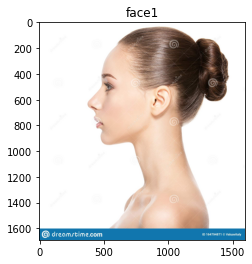

In [9]:
path='../data/test/profile_test/profile1.jpg'
face1 = Face('face1', image_or_path=path)
face1.show()
face1.show_predictions()

Sunglasses image
sunglasses: 0.93


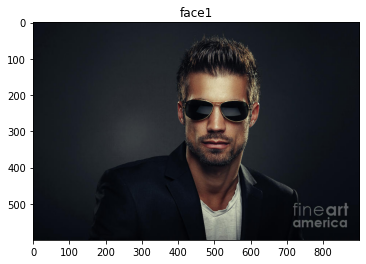

In [14]:
path='../data/test/sunglasses_test/sunglass1.jpg'
face1 = Face('face1', image_or_path=path)
face1.show()
face1.show_predictions()

Blurry image
blurry: 0.998


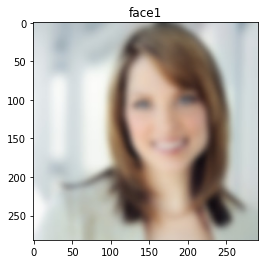

In [17]:
path='../data/test/blurry_test/blurry12.jpg'
face1 = Face('face1', image_or_path=path)
face1.show()
face1.show_predictions()